# Introduction


The original link https://raphaelvallat.com/bandpower.html

One of the most widely used method to analyze EEG data is to decompose the signal into functionally distinct frequency bands, such as delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (12–30 Hz), and gamma (30–100 Hz).

This implies the decomposition of the EEG signal into frequency components, which is commonly achieved through Fourier transforms. The almost invariably used algorithm to compute the Fourier transform (and arguably the most important signal processing algorithm) is the Fast Fourier Transform (FFT), which returns, for each frequency bin, a complex number from which one can then easily extract the amplitude and phase of the signal at that specific frequency. In spectral analysis, it is then common to take the magnitude-squared of the FFT to obtain an estimate of the power spectral density (or power spectrum, or periodogram), expressed in (micro)-Volts2 per Hertz in the case of EEG data.

![EEG-BP](./data/img_notebook/EEG_BP.png)

![EEG-brainwaves](./data/img_notebook/brainwaves.png)

PS: The img aboves are the searching results from google, there are others photos in the folder ' data/img_notebook'

Although a myriad of analyses can be performed from the power spectral density, this tuto are going to focus here on a very simple one: the average band power, which consists in computing a single number that summarizes the contribution of the given frequency band to the overall power of the signal. This could be particularly useful in a machine-learning approach, when often you will want to extract some keys features from your data (and have a single number that could summarize a particular aspect of your data).

The average bandpower is also a very relevant metric for sleep research because it allows to differentiate between the different sleep stages. For instance, deep sleep is characterized by its predominance of slow-waves with a frequency range comprised between 0.5 to 4 Hz (i.e. delta band), which reflects a synchronized brain activity. Conversely, wakefulness is characterized by very little delta activity and much more higher-frequencies activity. Therefore, if you were to compute the delta bandpower for both deep sleep and wakefulness, the former would be very high and the latter very low.

## Data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
sns.set(font_scale=1.2)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#openbci_datapath = './data/OpenBCI_GUI-v5-meditation.txt'
openbci_datapath_2 = './data/OpenBCI_GUI-v5-blinks-jawClench-alpha.txt'

names=['index', 'Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'X_acc', 'Y_acc', 'Z_acc',
       'unknow1','unknow2','unknow3','unknow4','unknow5','unknow6','unknow7','unknow8','unknow9','unknow10',
       'TimeStamp', 'Time']
usecols=['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'TimeStamp']

# you can also start from line 5, because the 6th line is all 0.0
data = pd.read_csv(openbci_datapath_2, sep=",", header=6, index_col=False, names=names)
print("OpenBCI data shape: ", data.shape)

OpenBCI data shape:  (22488, 24)


In [3]:
# data.info()

In [4]:
df_selected = data[usecols]
# print(df_selected.size)
Timestamps = (df_selected['TimeStamp'].to_numpy()[-1] - df_selected['TimeStamp'].to_numpy()[0])/1000
print("Total length of data: ", Timestamps, 's')

Total length of data:  89.83 s


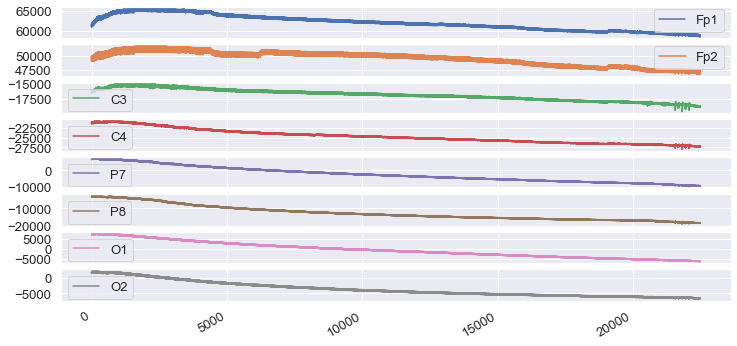

In [5]:
EEG_data = df_selected[['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']]
df = pd.DataFrame(EEG_data)
df[['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']].plot(subplots=True, figsize=(12, 6))
plt.show()

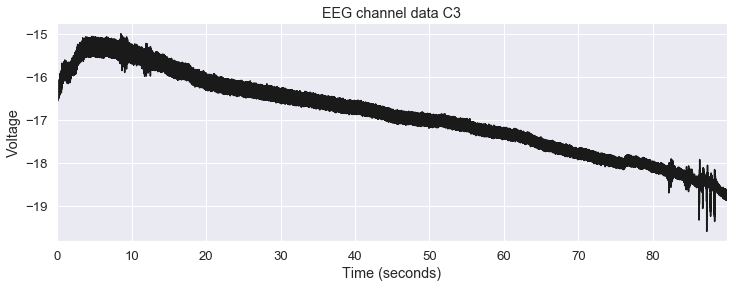

In [6]:
# Define sampling frequency and time vector
sf = 250
time = np.arange(len(df_selected['C3'])) / sf
# print(time.max())

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, df_selected['C3']/1000, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG channel data C3')
sns.despine()

## Computing the power spectral density

In order to compute the average bandpower in the delta band, we first need to compute an estimate of the power spectral density. The most widely-used method to do that is the Welch's periodogram, which consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping.

The Welch's method improves the accuracy of the classic periodogram. The reason is simple: EEG data are always time-varying, meaning that if you look at a 30 seconds of EEG data, it is very (very) unlikely that the signal will looks like a perfect sum of pure sines. Rather, the spectral content of the EEG changes over time, constantly modified by the neuronal activity at play under the scalp. Problem is, to return a true spectral estimate, a classic periodogram requires the spectral content of the signal to be stationnary (i.e. time-unvarying) over the time period considered. Because it is never the case, the periodogram is generally biased and contains way too much variance (see the end of this tutorial). By averaging the periodograms obtained over short segments of the windows, the Welch's method allows to drastically reduce this variance. This comes at the cost, however, of a lower frequency resolution. Indeed, the frequency resolution is defined by:

![Equation](./data/img_notebook/equation_1.png)

where 
F
s
 is the sampling frequency of the signal, 
N
 the total number of samples and 
t
 the duration, in seconds, of the signal. In other words, if we were to use the full length of our data (89.83 seconds), our final frequency resolution would be 
1
/
89.83
=
0.0111321384838
 Hz, which is 89(90) frequency bins per Hertz. By using a 4-second sliding window, we reduce this frequency resolution to 4 frequency bins per Hertz, i.e. each step represents 0.25 Hz.

How do we define the optimal window duration then? A commonly used approach is to take a window sufficiently long to encompasses at least two full cycles of the lowest frequency of interest. In our case, our lowest frequency of interest is 0.5 Hz so we will choose a window of 
2
/
0.5
=
4
 seconds.
 
Another conclusion from the equation above is that the only thing that increases frequency resolution is time. Changes in sampling frequency do not increase the frequency resolution but only the frequency coverage. Read more on this https://www.quora.com/How-does-the-sampling-rate-influence-the-frequency-resolution-in-frequency-spectrum-in-FFT

In [71]:
data = df_selected['C3'].to_numpy() # /1000

In [72]:
# Define window length (4 seconds)
win = 4 * sf
# win = 6 * sf
freqs, psd = signal.welch(data, sf, nperseg=win)
psd

array([7.05126611e+01, 7.22685660e+02, 2.85774011e+02, 2.73886637e+02,
       2.70955317e+02, 1.31643380e+02, 9.03938205e+01, 1.10795592e+02,
       9.03915559e+01, 4.47989555e+01, 3.21758663e+01, 4.14620113e+01,
       3.45622907e+01, 3.89641590e+01, 3.14155533e+01, 2.48701588e+01,
       2.11419358e+01, 1.70990240e+01, 1.86744203e+01, 9.06365718e+00,
       1.57134708e+01, 1.47361060e+01, 1.14925823e+01, 7.73701372e+00,
       1.42182372e+01, 1.54431512e+01, 5.25442312e+00, 5.29370639e+00,
       6.64280483e+00, 5.53298945e+00, 4.10486773e+00, 9.34778617e+00,
       9.56586289e+00, 4.87150682e+00, 3.18963011e+00, 3.71332444e+00,
       3.19509169e+00, 3.26014695e+00, 5.87554530e+00, 7.24629960e+00,
       7.82091758e+00, 8.59175852e+00, 8.75559543e+00, 1.02437749e+01,
       1.16769560e+01, 1.01055845e+01, 7.53114764e+00, 5.44692466e+00,
       3.97809324e+00, 3.73059353e+00, 3.63836433e+00, 2.99592967e+00,
       2.83498827e+00, 2.50919157e+00, 2.07590090e+00, 1.68169625e+00,
      

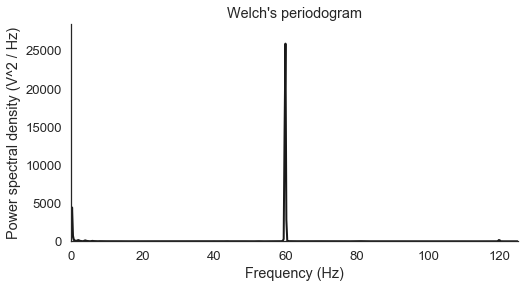

In [12]:
# Define window length (4 seconds)
win = 4 * sf
# win = 6 * sf
freqs, psd = signal.welch(data, sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

The freqs vector contains the x-axis (frequency bins) and the psd vector contains the y-axis (power spectral density). The units of the power spectral density, when working with EEG data, is usually micro-Volts-squared per Hz (
u
V
2
/
H
z
)

Note that the maximum value of the x-axis is always half the sampling frequency, which is exactly the Nyquist frequency. This is where the notion of frequency coverage comes into play: if our signal was sampled at 200 Hz instead of 100 Hz, the maximum value on the x-axis would be 200 / 2 = 100 Hz instead of 50 Hz. In other words, increasing the sampling frequency results in a larger frequency range.

## Defining the delta band
Now, before computing the average delta bandpower, we need to find the frequency bins that intersect the delta frequency range.

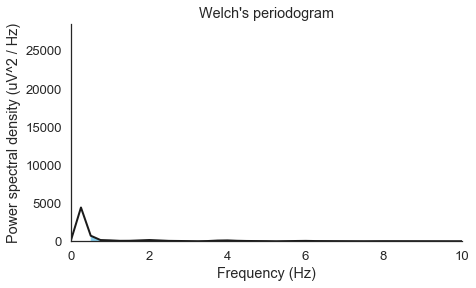

In [13]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

## Average band power
he absolute delta power is equal to the blue area of the previous plot. As there is no closed-form formula to integrate this area, we need to approximate it. This is commonly achieved using the composite Simpson's rule. The idea behind it is actually very simple: we decompose this area into several parabola and then sum the area of these parabola. Note that this could also be done using trapezoid (trapezoid rule) or rectangle (as in the Matlab bandpower function), but parabola typically give better estimates.

In [14]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 353.098 uV^2


## Relative power
In practice, rather than reporting the absolute band power, one may want to express the power in a frequency band as a percentage of the total power of the signal. This is called the relative band power. It can be calculated very easily from the above:

In [16]:
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.027


In other words, 2.7% of the total power of the signal is contained in the delta frequency band.

## Generalization
The function below is a generalization of the above which can be used to easily get the average absolute or relative power in a specific frequency band. It is very similar to the Matlab bandpower function, with the exceptions that it uses a Welch's periodogram instead of a classical periodogram, and it approximates the area using parabola instead of rectangles.

In [17]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp


## Ratio between two frequency bands
It is also very common to report the ratios between two frequency bands. For instance, the delta / beta ratio is a well-known index of slow-wave sleep quality. When computing ratios between two bands, it is important to control that the window length of the periodogram is the same for the two bands. Indeed, if you are using a different window length for the two bands, this will result in two different periodograms and the ratio will therefore be meaningless.

In [18]:
# Define the duration of the window to be 4 seconds
win_sec = 4

# Delta/beta ratio based on the absolute power
db = bandpower(data, sf, [0.5, 4], win_sec) / bandpower(data, sf, [12, 30], win_sec)

# Delta/beta ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], win_sec, True) / bandpower(data, sf, [12, 30], win_sec, True)

print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Delta/beta ratio (absolute): 2.826
Delta/beta ratio (relative): 2.826


## Using the multitaper method
Multitaper is a spectral analysis method first developed by David J. Thompson in 1982 in order to overcome some of the limitations of the classical spectral estimation techniques. It provides a more robust spectral estimation than the classical and Welch's periodograms, by combining the advantages of the two methods: high frequency resolution and low variance.

To understand how it works, encourage to read this paper by <a  href ="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5343535/">Prerau et al. (2017)</a>  that explains very well what is multitaper and how sleep research and sleep medicine could benefit from it. Another source that was useful for me was the <a  href ="https://fr.mathworks.com/help/examples.html">Matlab documentation on Multitaper spectral analyses</a> .

In a nutshell, the multitaper method starts by filtering the original signal with a set of optimal bandpass filter, called Slepian sequences (or DPSS). This filtering is done by convoluting the original signal with the Slepian sequences. Second, a classic periodogram is calculated for each of these new filtered (or "tapered") data and the final spectrum is then obtained by averaging over all the resulting periodogram. The real strength of the multitaper method comes from the fact that the Slepian sequences are orthogonal to all others and therefore the tapered signals provide statistically independent estimates of the underlying spectrum. In other words, each filtered signal will highlight one specific aspect of the spectral content of the signal.



![Schematic of multitaper spectral estimation (from Prerau et al. 2017)](./data/img_notebook/prerau_article.jpg)

<center>Schematic of multitaper spectral estimation (from Prerau et al. 2017)</center>

## Average bandpower using Multitaper
The multitaper spectral estimation method is implemented in the MNE-Python package. In the following example, I adapted the bandpower function that we have created previously to add the multitaper method. 

In [19]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

The above is an equation from the author, we encapsulate it so that it can be used directly to process all 8/16 signals 

In [ ]:
# to be finshed

Let's try our new function with the code below. One advantage of the Multitaper method compared to the Welch's method is that we do not need to specify a window duration as it will basically compute the periodogram on the whole signal. Since we are using the full length of the signal, the frequency resolution of the multitaper estimate will be 1 / 89.83 = 0.011 Hz.

In [20]:
# Multitaper delta power
bp = bandpower(data, sf, [0.5, 4], 'multitaper')
bp_rel = bandpower(data, sf, [0.5, 4], 'multitaper', relative=True)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel)

# Delta-beta ratio
# One advantage of the multitaper is that we don't need to define a window length.
db = bandpower(data, sf, [0.5, 4], 'multitaper') / bandpower(data, sf, [12, 30], 'multitaper')
# Ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], 'multitaper', relative=True) / \
                    bandpower(data, sf, [12, 30], 'multitaper', relative=True)
print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Absolute delta power: 631.612
Relative delta power: 0.001
Delta/beta ratio (absolute): 8.331
Delta/beta ratio (relative): 8.331


The results are very close to the one obtained using Welch's method. This should remain true as long as your data are not too noisy. However, if you are working with noisy data, the multitaper method will always provide a much more robust spectral estimation than Welch's.

Just for fun, let's compare the power spectral density estimate obtained using a classic periodogram, a Welch's periodogram, and the multitaper method:

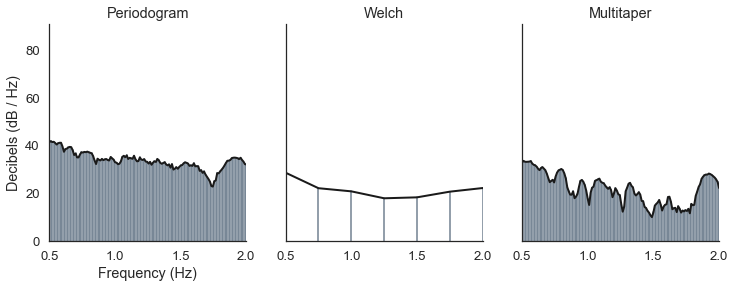

In [21]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import welch, periodogram
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax1.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax2.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax1.plot(freqs, psd, lw=lw, color=lc)
    ax2.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax1.set_title('Periodogram')
    ax2.set_title('Welch')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()

# Example: plot the 0.5 - 2 Hz band
plot_spectrum_methods(data, sf, 4, [0.5, 2], dB=True)

* The classic periodogram has a good frequency resolution (one frequency bin = 0.011 Hz) but way too much variance.
* The Welch's periodogram has a low variance, at the cost of a lower frequency resolution (one frequency bin = 0.25 Hz).
* The multitaper periodogram has the advantages of the two previous methods: high frequency resolution and low variance.

## Computational cost

In [22]:
%timeit bandpower(data, sf, [0.5, 4], method="welch", relative=True)
%timeit bandpower(data, sf, [0.5, 4], method="multitaper", relative=True)

841 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
175 ms ± 6.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The multitaper is more computationally intensive than other methods. In the example above, the multitaper method was about 300-400 times slower than Welch's method. Using 89.83-sec of data sampled at 259 Hz, the difference in the time of execution was about ~175ms. Now, imagine that you have several hours of data and several channels sampled at 1000 Hz; what was barely perceptible on our 89.83-sec data could turn into a difference of several hours (e.g. 1 min for Welch, ~5 hours for the multitaper). This is definitely something that you may want to consider when deciding which method to use.

Second, although the multitaper methods always provide a more robust spectral estimation, I think that choosing which technique one should use depends on the data at hand. For example, if you have clean data acquired on young healthy individuals, there's a good chance that the multitaper spectral estimation will not differ that much from the Welch's estimate. Furthermore, Welch's method is probably the most used spectral estimation technique to this day and is quite intuitive to understand. By contrast, the multitaper is a relatively new method that is conceptually harder to grasp.

# All 8 channels

For now we have some C3 channel band power information, but we didn't got all band power, so in this part I will finish C3 and other 7 channels(for our example data.)

In [26]:
ch_names = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']

In [33]:
# frequency scale range in OpenBCI GUI
delta =  [0.5, 4]   # [0.3, 4]
theta =  [4, 8] 
alpha =  [8, 13]
beta = [13, 32]
gamma =  [32, 100]  # [30, above]

## Channel C3

And because those data are raw data EEG, in case of the existing of noisy, I will use multitaper way

In [34]:
data = df_selected['C3'].to_numpy()

# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'multitaper')
bp_rel = bandpower(data, sf, delta, 'multitaper', relative=True)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta, 'multitaper')
bp_rel = bandpower(data, sf, theta, 'multitaper', relative=True)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'multitaper')
bp_rel = bandpower(data, sf, alpha, 'multitaper', relative=True)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'multitaper')
bp_rel = bandpower(data, sf, beta, 'multitaper', relative=True)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'multitaper')
bp_rel = bandpower(data, sf, gamma, 'multitaper', relative=True)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 631.612
Relative delta power: 0.001

Absolute theta power: 39.604
Relative theta power: 0.000

Absolute alpha power: 36.588
Relative alpha power: 0.000

Absolute beta power: 80.038
Relative beta power: 0.000

Absolute gamma power: 10844.461
Relative gamma power: 0.015


In fact, you can find that all 5 relative band power sum is not 1, so that's because we need to do filter or denoisying?

why all frequency are in 0-0.5  100-above?

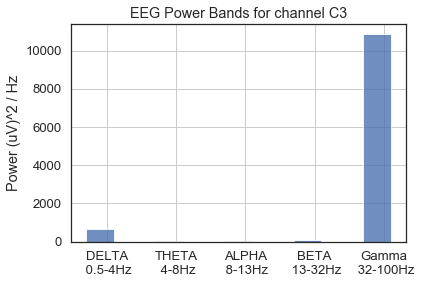

In [42]:
# plt.figure(figsize=(8,12), dpi=90)
y = [631.612, 39.604, 36.588, 80.038, 10844.461]
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel C3")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

In [43]:
# Delta-beta ratio
# One advantage of the multitaper is that we don't need to define a window length.
db = bandpower(data, sf, [0.5, 4], 'multitaper') / bandpower(data, sf, [12, 30], 'multitaper')
# Ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], 'multitaper', relative=True) / \
                    bandpower(data, sf, [12, 30], 'multitaper', relative=True)
print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Delta/beta ratio (absolute): 8.331
Delta/beta ratio (relative): 8.331


If you want to try other ratio, just change the frequency range.

Like delta - aplha :


In [44]:
# Delta-aplha ratio

db = bandpower(data, sf, delta, 'multitaper') / bandpower(data, sf, alpha, 'multitaper')
# Ratio based on the relative power
db_rel = bandpower(data, sf, delta, 'multitaper', relative=True) / \
                    bandpower(data, sf, alpha, 'multitaper', relative=True)
print('Delta/alpha ratio (absolute): %.3f' % db)
print('Delta/alpha ratio (relative): %.3f' % db_rel)

Delta/alpha ratio (absolute): 17.263
Delta/alpha ratio (relative): 17.263


## Channel Fp1

In [46]:
data = df_selected['Fp1'].to_numpy()
y = list()
# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'multitaper')
bp_rel = bandpower(data, sf, delta, 'multitaper', relative=True)
y.append(bp)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta, 'multitaper')
bp_rel = bandpower(data, sf, theta, 'multitaper', relative=True)
y.append(bp)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'multitaper')
bp_rel = bandpower(data, sf, alpha, 'multitaper', relative=True)
y.append(bp)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'multitaper')
bp_rel = bandpower(data, sf, beta, 'multitaper', relative=True)
y.append(bp)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'multitaper')
bp_rel = bandpower(data, sf, gamma, 'multitaper', relative=True)
y.append(bp)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 925.631
Relative delta power: 0.000

Absolute theta power: 211.804
Relative theta power: 0.000

Absolute alpha power: 41.188
Relative alpha power: 0.000

Absolute beta power: 61.564
Relative beta power: 0.000

Absolute gamma power: 34517.047
Relative gamma power: 0.011


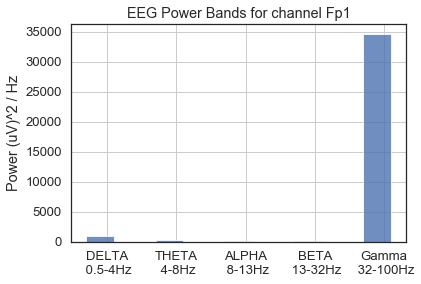

In [47]:
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel Fp1")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

## Channel Fp2

In [48]:
data = df_selected['Fp2'].to_numpy()
y = list()
# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'multitaper')
bp_rel = bandpower(data, sf, delta, 'multitaper', relative=True)
y.append(bp)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta, 'multitaper')
bp_rel = bandpower(data, sf, theta, 'multitaper', relative=True)
y.append(bp)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'multitaper')
bp_rel = bandpower(data, sf, alpha, 'multitaper', relative=True)
y.append(bp)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'multitaper')
bp_rel = bandpower(data, sf, beta, 'multitaper', relative=True)
y.append(bp)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'multitaper')
bp_rel = bandpower(data, sf, gamma, 'multitaper', relative=True)
y.append(bp)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 1136.926
Relative delta power: 0.001

Absolute theta power: 207.346
Relative theta power: 0.000

Absolute alpha power: 44.188
Relative alpha power: 0.000

Absolute beta power: 61.241
Relative beta power: 0.000

Absolute gamma power: 68658.851
Relative gamma power: 0.053


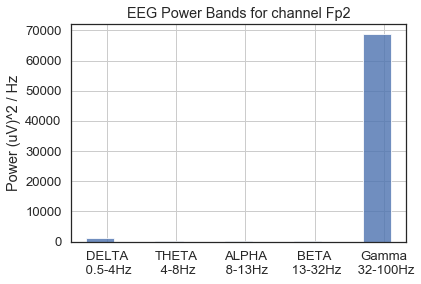

In [49]:
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel Fp2")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

## Channel C4

In [50]:
data = df_selected['C4'].to_numpy()
y = list()
# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'multitaper')
bp_rel = bandpower(data, sf, delta, 'multitaper', relative=True)
y.append(bp)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta, 'multitaper')
bp_rel = bandpower(data, sf, theta, 'multitaper', relative=True)
y.append(bp)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'multitaper')
bp_rel = bandpower(data, sf, alpha, 'multitaper', relative=True)
y.append(bp)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'multitaper')
bp_rel = bandpower(data, sf, beta, 'multitaper', relative=True)
y.append(bp)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'multitaper')
bp_rel = bandpower(data, sf, gamma, 'multitaper', relative=True)
y.append(bp)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 3067.544
Relative delta power: 0.001

Absolute theta power: 32.825
Relative theta power: 0.000

Absolute alpha power: 35.977
Relative alpha power: 0.000

Absolute beta power: 67.895
Relative beta power: 0.000

Absolute gamma power: 6845.558
Relative gamma power: 0.003


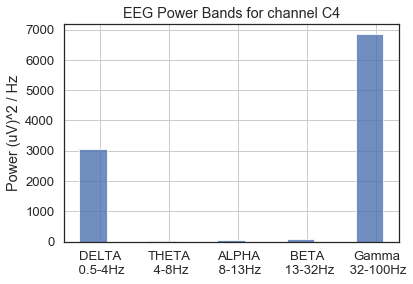

In [51]:
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel C4")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

## Channel P7

In [55]:
data = df_selected['P7'].to_numpy()
y = list()
# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'multitaper')
bp_rel = bandpower(data, sf, delta, 'multitaper', relative=True)
y.append(bp)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta, 'multitaper')
bp_rel = bandpower(data, sf, theta, 'multitaper', relative=True)
y.append(bp)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'multitaper')
bp_rel = bandpower(data, sf, alpha, 'multitaper', relative=True)
y.append(bp)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'multitaper')
bp_rel = bandpower(data, sf, beta, 'multitaper', relative=True)
y.append(bp)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'multitaper')
bp_rel = bandpower(data, sf, gamma, 'multitaper', relative=True)
y.append(bp)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 19729.029
Relative delta power: 0.001

Absolute theta power: 19.789
Relative theta power: 0.000

Absolute alpha power: 35.513
Relative alpha power: 0.000

Absolute beta power: 62.139
Relative beta power: 0.000

Absolute gamma power: 19684.528
Relative gamma power: 0.001


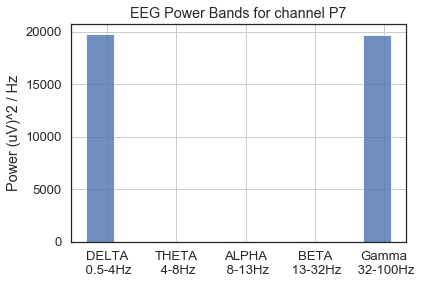

In [56]:
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel P7")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

## Channel P8

In [57]:
data = df_selected['P8'].to_numpy()
y = list()
# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'multitaper')
bp_rel = bandpower(data, sf, delta, 'multitaper', relative=True)
y.append(bp)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta, 'multitaper')
bp_rel = bandpower(data, sf, theta, 'multitaper', relative=True)
y.append(bp)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'multitaper')
bp_rel = bandpower(data, sf, alpha, 'multitaper', relative=True)
y.append(bp)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'multitaper')
bp_rel = bandpower(data, sf, beta, 'multitaper', relative=True)
y.append(bp)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'multitaper')
bp_rel = bandpower(data, sf, gamma, 'multitaper', relative=True)
y.append(bp)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 18953.085
Relative delta power: 0.001

Absolute theta power: 23.816
Relative theta power: 0.000

Absolute alpha power: 42.584
Relative alpha power: 0.000

Absolute beta power: 81.565
Relative beta power: 0.000

Absolute gamma power: 21003.821
Relative gamma power: 0.001


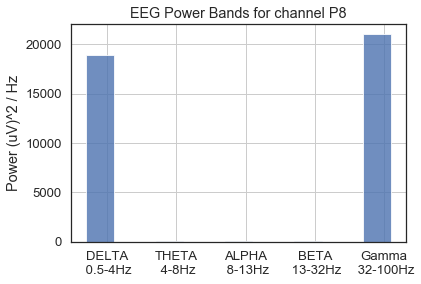

In [58]:
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel P8")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

## Channel O1

In [61]:
data = df_selected['O1'].to_numpy()
y = list()
# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'multitaper')
bp_rel = bandpower(data, sf, delta, 'multitaper', relative=True)
y.append(bp)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta, 'multitaper')
bp_rel = bandpower(data, sf, theta, 'multitaper', relative=True)
y.append(bp)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'multitaper')
bp_rel = bandpower(data, sf, alpha, 'multitaper', relative=True)
y.append(bp)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'multitaper')
bp_rel = bandpower(data, sf, beta, 'multitaper', relative=True)
y.append(bp)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'multitaper')
bp_rel = bandpower(data, sf, gamma, 'multitaper', relative=True)
y.append(bp)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 13062.962
Relative delta power: 0.001

Absolute theta power: 25.533
Relative theta power: 0.000

Absolute alpha power: 95.359
Relative alpha power: 0.000

Absolute beta power: 76.972
Relative beta power: 0.000

Absolute gamma power: 21593.188
Relative gamma power: 0.002


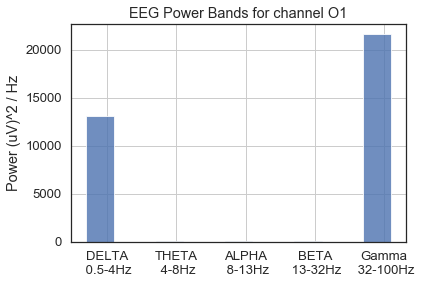

In [62]:
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel O1")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

## Channel O2

In [63]:
data = df_selected['O2'].to_numpy()
y = list()
# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'multitaper')
bp_rel = bandpower(data, sf, delta, 'multitaper', relative=True)
y.append(bp)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta, 'multitaper')
bp_rel = bandpower(data, sf, theta, 'multitaper', relative=True)
y.append(bp)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'multitaper')
bp_rel = bandpower(data, sf, alpha, 'multitaper', relative=True)
y.append(bp)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'multitaper')
bp_rel = bandpower(data, sf, beta, 'multitaper', relative=True)
y.append(bp)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'multitaper')
bp_rel = bandpower(data, sf, gamma, 'multitaper', relative=True)
y.append(bp)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 5904.245
Relative delta power: 0.001

Absolute theta power: 27.922
Relative theta power: 0.000

Absolute alpha power: 95.326
Relative alpha power: 0.000

Absolute beta power: 81.564
Relative beta power: 0.000

Absolute gamma power: 19536.788
Relative gamma power: 0.004


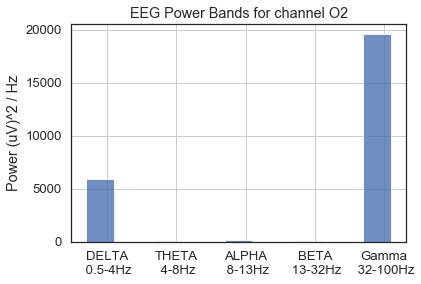

In [64]:
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel O2")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

You can find that's really strange, barely no theta, alpha, beta.

It's not the same from the playback history in the GUI application

In [65]:
data = df_selected['O2'].to_numpy()
y = list()
# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'welch', win_sec)
bp_rel = bandpower(data, sf, delta, 'welch', win_sec, relative=True)
y.append(bp)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta,  'welch', win_sec)
bp_rel = bandpower(data, sf, theta, 'welch', win_sec, relative=True)
y.append(bp)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'welch', win_sec)
bp_rel = bandpower(data, sf, alpha, 'welch', win_sec, relative=True)
y.append(bp)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'welch', win_sec)
bp_rel = bandpower(data, sf, beta, 'welch', win_sec, relative=True)
y.append(bp)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'welch', win_sec)
bp_rel = bandpower(data, sf, gamma, 'welch', win_sec, relative=True)
y.append(bp)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 230.531
Relative delta power: 0.009

Absolute theta power: 52.371
Relative theta power: 0.002

Absolute alpha power: 87.773
Relative alpha power: 0.003

Absolute beta power: 88.147
Relative beta power: 0.004

Absolute gamma power: 18651.718
Relative gamma power: 0.743


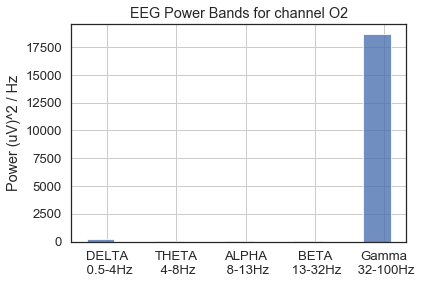

In [66]:
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel O2")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

If we use welch, the value of delta will also be so small.

Another point need to know, the graph in function is plotted every time for all channel, it's different compared to ours, our graph count all the power in a whole time for one channel;

But it's still a bit weird that our data theta alpha beta are so small.
 
So now test another data, check what will happen:

In [67]:
openbci_datapath = './data/OpenBCI_GUI-v5-meditation.txt'
# openbci_datapath_2 = './data/OpenBCI_GUI-v5-blinks-jawClench-alpha.txt'

names=['index', 'Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'X_acc', 'Y_acc', 'Z_acc',
       'unknow1','unknow2','unknow3','unknow4','unknow5','unknow6','unknow7','unknow8','unknow9','unknow10',
       'TimeStamp', 'Time']
usecols=['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'TimeStamp']

# you can also start from line 5, because the 6th line is all 0.0
data = pd.read_csv(openbci_datapath, sep=",", header=6, index_col=False, names=names)
# print("OpenBCI data shape: ", data.shape)
df_selected = data[usecols]
# print(df_selected.size)
Timestamps = (df_selected['TimeStamp'].to_numpy()[-1] - df_selected['TimeStamp'].to_numpy()[0])/1000
print("Total length of data: ", Timestamps, 's')

Total length of data:  703.108 s


In [68]:
data = df_selected['O2'].to_numpy() # /1000

In [69]:
data = df_selected['O2'].to_numpy()
y = list()
# Multitaper band power
print()
bp = bandpower(data, sf, delta, 'multitaper')
bp_rel = bandpower(data, sf, delta, 'multitaper', relative=True)
y.append(bp)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, theta, 'multitaper')
bp_rel = bandpower(data, sf, theta, 'multitaper', relative=True)
y.append(bp)
print('Absolute theta power: %.3f' % bp)
print('Relative theta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, alpha, 'multitaper')
bp_rel = bandpower(data, sf, alpha, 'multitaper', relative=True)
y.append(bp)
print('Absolute alpha power: %.3f' % bp)
print('Relative alpha power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, beta, 'multitaper')
bp_rel = bandpower(data, sf, beta, 'multitaper', relative=True)
y.append(bp)
print('Absolute beta power: %.3f' % bp)
print('Relative beta power: %.3f' % bp_rel) 

print()
bp = bandpower(data, sf, gamma, 'multitaper')
bp_rel = bandpower(data, sf, gamma, 'multitaper', relative=True)
y.append(bp)
print('Absolute gamma power: %.3f' % bp)
print('Relative gamma power: %.3f' % bp_rel) 


Absolute delta power: 15792.178
Relative delta power: 0.004

Absolute theta power: 1147.831
Relative theta power: 0.000

Absolute alpha power: 458.005
Relative alpha power: 0.000

Absolute beta power: 446.056
Relative beta power: 0.000

Absolute gamma power: 1339.197
Relative gamma power: 0.000


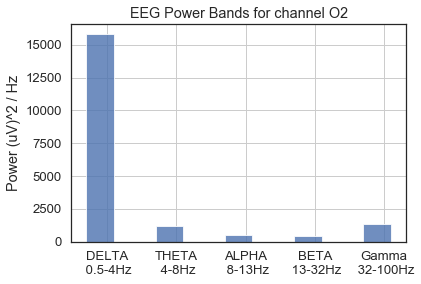

In [70]:
x = range(len(y))
label_list = ["DELTA\n 0.5-4Hz", "THETA\n 4-8Hz", "ALPHA\n 8-13Hz", "BETA\n 13-32Hz", "Gamma\n 32-100Hz"]
plt.bar(x, height=y, width=0.4, alpha=0.8)
plt.title("EEG Power Bands for channel O2")
plt.ylabel("Power (uV)^2 / Hz")
plt.xticks([index + 0.1 for index in x], label_list)
plt.grid()
plt.show()

You can find in this data, the value of 5 band power is different, so for I think, there is no problem, though the graph is not so good compared to GUI graph, but I think data's own limit and time range and channel range are the main reasons.